In [1]:
# BLOCK 1
import numpy as np
import os
import time
import matplotlib
import matplotlib.pyplot as mp
from PIL import Image
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

import torch
torch.manual_seed(22)   

import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from torch.optim.lr_scheduler import StepLR

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"     # these lines solve a numpy multiple installation conflict


if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

In [2]:
# BLOCK 2

dataDir = 'resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)



There are 58954 images in 6 distinct categories
Label names: ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]
Image dimensions: 64 x 64


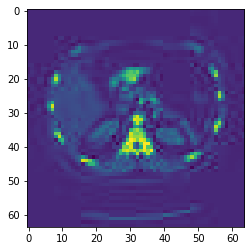

(64, 64)

In [3]:
# TEST
# to print an image
img=Image.open(imageFilesList[0])
arr=np.array(img)
mp.imshow(arr)
mp.show()

img.size

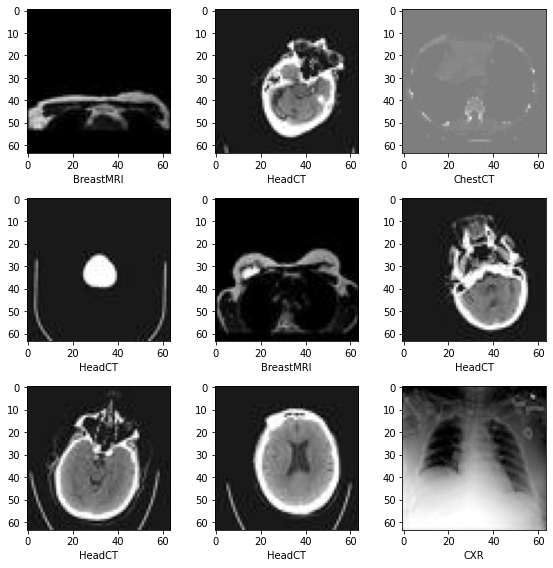

In [4]:
# BLOCK 3
mp.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Take a random sample of 9 images and
    im = Image.open(imageFilesList[k])                      #      plot and label them
    arr = np.array(im)
    mp.subplot(3,3,i+1)
    mp.xlabel(classNames[imageClass[k]])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

In [5]:
# BLOCK 4
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z

In [6]:
# BLOCK 5

imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

Rescaled min pixel value = -0.786; Max = 0.972; Mean = -3.35e-09


In [7]:
# BLOCK 6
validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)


Training images = 47381 Validation = 5833 Testing = 5740


In [8]:
# BLOCK 7

trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]

In [9]:
# BLOCK 8

class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        numConvs1 = 7
        convSize1 = 7
        numConvs2 = 14
        convSize2 = 9
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.elu(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [10]:
# BLOCK 9

model = MedNet(imageWidth,imageHeight,numClass).to(dev)

In [11]:
# BLOCK 10

learnRate = 0.001          # Define a learning rate.
maxEpochs = 50            # Maximum training epochs
t2vEpochs = 10             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 1024           # Batch size. Going too large will cause an out-of-memory error.
improvment_ratio = 0.98   # improvment ratio for epoch continuation
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti =optim.Adam(model.parameters(),lr=learnRate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opti, gamma=0.1)

Epoch_losses=[]
Valid_losses=[]

bestloss = 10
count=0



for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats

    Epoch_losses.append(epochLoss)
    Valid_losses.append(validLoss)

    
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss < bestloss * improvment_ratio:
        bestloss = validLoss
        count = 0
        torch.save(model.state_dict(),'saved_model_12c.pt')
    else:
        count += 1
    if count >= t2vEpochs:
        print('result are ok')
        break




Epoch =   0; Training loss = 0.2337; Validation loss = 0.0416
Epoch =   1; Training loss = 0.0291; Validation loss = 0.0201
Epoch =   2; Training loss = 0.0117; Validation loss = 0.0136
Epoch =   3; Training loss = 0.0057; Validation loss = 0.0108
Epoch =   4; Training loss = 0.0041; Validation loss = 0.0123
Epoch =   5; Training loss = 0.0030; Validation loss = 0.0186
Epoch =   6; Training loss = 0.0017; Validation loss = 0.0080
Epoch =   7; Training loss = 0.0013; Validation loss = 0.0118
Epoch =   8; Training loss = 0.0019; Validation loss = 0.0088
Epoch =   9; Training loss = 0.0016; Validation loss = 0.0070
Epoch =  10; Training loss = 0.0009; Validation loss = 0.0063
Epoch =  11; Training loss = 0.0010; Validation loss = 0.0117
Epoch =  12; Training loss = 0.0004; Validation loss = 0.0084
Epoch =  13; Training loss = 0.0001; Validation loss = 0.0091
Epoch =  14; Training loss = 0.0001; Validation loss = 0.0088
Epoch =  15; Training loss = 0.0002; Validation loss = 0.0086
Epoch = 

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

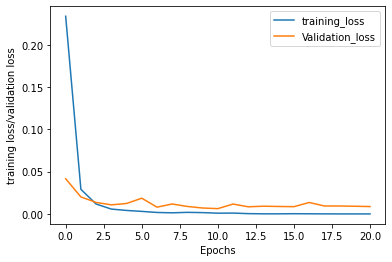

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(0,len(Epoch_losses)),Epoch_losses, label="training_loss")
plt.plot(range(0,len(Valid_losses)),Valid_losses, label="Validation_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("training loss/validation loss")
plt.plot

In [13]:
# BLOCK 11

confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)

Correct predictions:  5733 of 5740
Confusion Matrix:
[[972   0   0   0   0   0]
 [  0 898   0   0   0   0]
 [  1   0 991   0   0   0]
 [  0   0   0 963   0   0]
 [  1   0   1   3 934   0]
 [  0   0   0   0   1 975]]
['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']


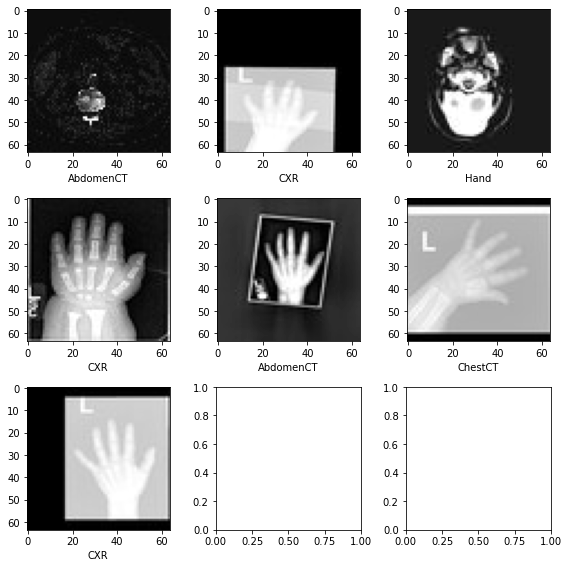

In [14]:
# BLOCK 12

def scaleBack(x):               # Pass a tensor, return a numpy array from 0 to 1
    if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Remove channel (grayscale anyway)

model.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(nTest)        # Shuffle test data
testX = testX[permute,:,:,:]
testY = testY[permute]
for j in range(testBats):              # Iterate over test batches
    batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model(batX)                 # Pass test batch through model
    pred = yOut.max(1)[1].tolist()     # Generate predictions by finding the max Y values
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # Compare the actual y value to the prediction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(classNames[pred[i]])      # Label image with what the model thinks it is
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()